In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import dill
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import lightning as L
from collections import OrderedDict

import sys
sys.path.append("../../efish-physics-model/objects")
sys.path.append("../../efish-physics-model/helper_functions")
sys.path.append("../../efish-physics-model/uniform_points_generation")
sys.path.append("../end-to-end")

from electric_images_dataset import ElectricImagesDataset
from ElectricPropertiesNN import ElectricPropertiesNN
from ElectricPropertiesNN_PL import ElectricPropertiesNN_PL

In [3]:
data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_18-characterization_dataset"
# data_dir_name = "/home/ssd2tb/dturcu/electric_fish_processed_data/data-2024_06_05-characterization_dataset"
# data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_13-characterization_dataset_mockup"
dataset = pd.read_pickle(f"{data_dir_name}/dataset.pkl")
h5py_file = h5py.File(f"{data_dir_name}/responses.hdf5",'r')["responses"]

In [4]:
worm_id = 31  # 297135
fish = dataset["fish"]["dataframe"]["objs"][0]
base_stim = dataset["electric_images"]["base"]["responses"][0]
modulation = (h5py_file[worm_id] / base_stim - 1) * 100

In [6]:
fish.visualize_scatter(intensity=modulation[:,0], show_normals=1, show_point_currents=5, marker_alpha=1)
print()

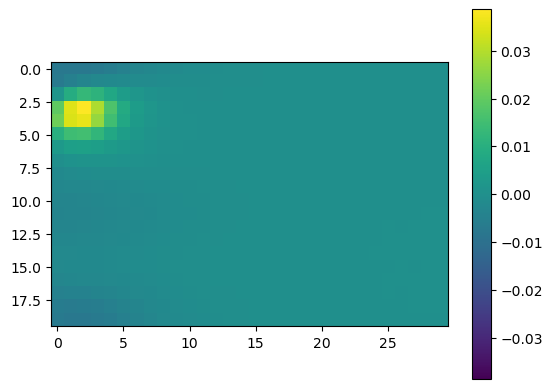

In [5]:
img_data = modulation.reshape(30,20,2).transpose(1,0,2)[:,:,1]
vval = np.max(np.abs(img_data))
plt.imshow(img_data, cmap="viridis", vmin=-vval, vmax=vval)
plt.colorbar()
plt.show()

In [6]:
dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)

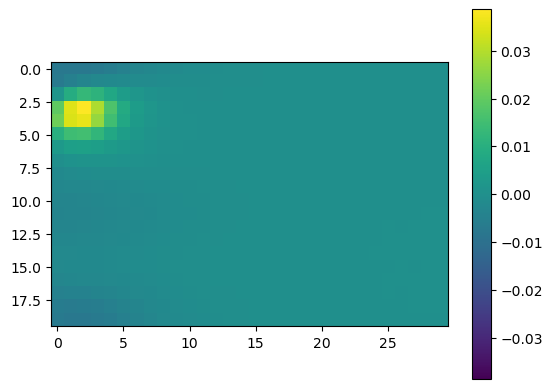

In [7]:
img_data = dset[worm_id][0][1]
vval = np.max(np.abs(img_data))
plt.imshow(img_data, cmap="viridis", vmin=-vval, vmax=vval)
plt.colorbar()
plt.show()

In [8]:
dloader = DataLoader(dset, batch_size=3200, shuffle=True)
batch = next(iter(dloader))
batch[0].shape, batch[1].shape

(torch.Size([3200, 2, 20, 30]), torch.Size([3200, 6]))

In [13]:
model_PL = ElectricPropertiesNN_PL(
    kernel_size=7,
    in_channels=2,
    poly_degree_distance=4,
    poly_degree_radius=3,
    activation="relu",
    input_noise_std=0.01,
    input_noise_type="additive",
)

In [14]:
out_model, features, scale_multiplier_distance, scale_multiplier_radius = model_PL.model(batch[0], batch[1][:,1], batch[1][:,3], return_features_and_multiplier=True)

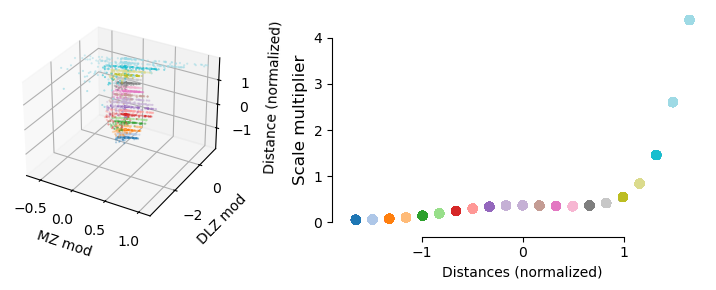

In [15]:
distances = batch[1][:, 1]

fig = plt.figure(figsize=(8, 3))
# plot the 3D feature space of MZ responses, DLZ responses, and distance
ax3D = fig.add_subplot(121, projection="3d")
ax3D.scatter(
    features[:, 0].detach().cpu().numpy(),
    features[:, 1].detach().cpu().numpy(),
    distances,
    c=distances,
    cmap="tab20",
    s=1,
    marker=".",
)
ax3D.set_xlabel("MZ mod", fontsize=10)
ax3D.set_ylabel("DLZ mod", fontsize=10)
ax3D.set_zlabel("Distance (normalized)", fontsize=10)  # type: ignore
# plot the scale function with distance
ax = fig.add_subplot(122)
ax.scatter(distances, scale_multiplier_distance.detach().cpu().numpy(), c=distances, cmap="tab20")
ax.set_xlabel("Distances (normalized)", fontsize=10)
ax.set_ylabel("Scale multiplier", fontsize=12)
sns.despine(ax=ax, offset=5, trim=True)
plt.tight_layout()
plt.show()

# Miscellaneous code

### Inspect R&C signal with filters and maxpooling

In [ ]:
data_dir_name = "/home/ssd2tb/dturcu/electric_fish_processed_data/data-2024_06_13-characterization_dataset"
# data_dir_name = "/home/ssd2tb/dturcu/electric_fish_processed_data/data-2024_06_13-characterization_dataset"
# data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_18-characterization_dataset"
dataset = pd.read_pickle(f"{data_dir_name}/dataset.pkl")
h5py_file = h5py.File(f"{data_dir_name}/responses.hdf5",'r')["responses"]
worm_properties = h5py.File(
    f"{data_dir_name}/torch_dataset_preprocess-worms_properties.hdf5", "r"
)["worms_properties"][:]

In [ ]:
ids = np.where(
    (worm_properties[:, 0] == worm_properties[50000, 0])
    # & (worm_properties[:, 1] == worm_properties[50, 1])
    & (worm_properties[:, 2] == worm_properties[50000, 2])
    & (worm_properties[:, 3] == worm_properties[50000, 3])
)[0]

In [ ]:
worm_id = ids[11]
fish = dataset["fish"]["dataframe"]["objs"][0]
base_stim = dataset["electric_images"]["base"]["responses"][0]
modulation = (h5py_file[worm_id] / base_stim - 1) * 100
modulation = modulation.reshape(30, 20, 2).transpose(2, 1, 0)

In [ ]:
img_data = modulation[1]
vval = np.max(np.abs(img_data))
plt.imshow(img_data, cmap="viridis", vmin=-vval, vmax=vval)
plt.colorbar()
plt.show()

In [ ]:
modulations = (h5py_file[ids] / base_stim - 1) * 100
modulations = torch.Tensor(modulations.reshape(-1, 30, 20, 2).transpose(0, 3, 2, 1))
processed = nn.functional.conv2d(modulations, torch.Tensor(np.ones([2,1,7,7]) / np.ones([2,1,7,7]).sum()), groups=2)

features = []
for i in range(processed.shape[1]):
    feat = processed[:, i].reshape(modulations.shape[0], -1)
    feat = feat.abs().max(1).values * feat[torch.arange(modulations.shape[0]), feat.abs().argmax(1)].sign()
    features.append(feat)
features = np.vstack(features).T

In [ ]:
plt.scatter(*features.T, s=1)
plt.show()

### Select ElectricPropertiesDataset from larger data

In [16]:
data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_18-characterization_dataset"
id_x = 6
id_y = 0
id_z = 5
id_r = 13
fish_t = 20
fish_u = 30
dataset = pd.read_pickle(f"{data_dir_name}/dataset.pkl")
h5py_file = h5py.File(f"{data_dir_name}/responses.hdf5",'r')["responses"]

### Variable Distance and Radius

main_ids = dataset["worms"]["dataframe"][
    (dataset["worms"]["dataframe"]["position_xs"] == id_x)
    & (dataset["worms"]["dataframe"]["position_zs"] == id_z)
].index
worms_properties = dataset["worms"]["dataframe"].loc[main_ids].copy()
print(worms_properties.shape)

for k in worms_properties:
    worms_properties[k] = worms_properties[k].apply(lambda x: dataset["worms"][k][x])
worms_properties["resistances"] = worms_properties["resistances"].apply(np.log10)
worms_properties["capacitances"] = worms_properties["capacitances"].apply(np.log10)
print(worms_properties.shape)

worms_properties_stats = {}
for k in worms_properties:
    worms_properties_stats[k] = {
        "mean": worms_properties[k].mean(),
        "std": worms_properties[k].std(),
    }
    worms_properties[k] = (
        worms_properties[k] - worms_properties_stats[k]["mean"]
    ) / (worms_properties_stats[k]["std"] + 1e-10)
worms_properties = (
    worms_properties[["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]]
    .to_numpy()
    .astype(np.float32)
)
print("WP: ", worms_properties.shape)
main_ids = main_ids.to_numpy()
base_response = dataset["electric_images"]["base"]["responses"][0]
print(base_response.shape, h5py_file.shape)
responses = []
for main_id in main_ids:
    responses.append(h5py_file[main_id])
responses = np.array(responses)
print(responses.shape)
modulations = (responses / base_response - 1).reshape(-1, fish_u, fish_t, 2).transpose(0, 3, 2, 1).astype(np.float32) * 100
print(modulations.shape)
dill.dump((modulations, worms_properties), open("electric_properties_data.pkl", "wb"))

(159600, 6)
(159600, 6)
WP:  (159600, 6)
(600, 2) (33356400, 600, 2)
(159600, 600, 2)
(159600, 2, 20, 30)


In [17]:
### Variable Distance BUT Fixed Radius

main_ids = dataset["worms"]["dataframe"][
    (dataset["worms"]["dataframe"]["position_xs"] == id_x)
    & (dataset["worms"]["dataframe"]["position_zs"] == id_z)
    & (dataset["worms"]["dataframe"]["radii"] == id_r)
].index
worms_properties = dataset["worms"]["dataframe"].loc[main_ids].copy()
print(worms_properties.shape)

for k in worms_properties:
    worms_properties[k] = worms_properties[k].apply(lambda x: dataset["worms"][k][x])
worms_properties["resistances"] = worms_properties["resistances"].apply(np.log10)
worms_properties["capacitances"] = worms_properties["capacitances"].apply(np.log10)
print(worms_properties.shape)

worms_properties_stats = {}
for k in worms_properties:
    worms_properties_stats[k] = {
        "mean": worms_properties[k].mean(),
        "std": worms_properties[k].std(),
    }
    worms_properties[k] = (
        worms_properties[k] - worms_properties_stats[k]["mean"]
    ) / (worms_properties_stats[k]["std"] + 1e-10)
worms_properties = (
    worms_properties[["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]]
    .to_numpy()
    .astype(np.float32)
)
print("WP: ", worms_properties.shape)
main_ids = main_ids.to_numpy()
base_response = dataset["electric_images"]["base"]["responses"][0]
print(base_response.shape, h5py_file.shape)
responses = []
for main_id in main_ids:
    responses.append(h5py_file[main_id])
responses = np.array(responses)
print(responses.shape)
modulations = (responses / base_response - 1).reshape(-1, fish_u, fish_t, 2).transpose(0, 3, 2, 1).astype(np.float32) * 100
print(modulations.shape)
dill.dump((modulations, worms_properties), open("electric_properties_data-fixed_radius.pkl", "wb"))

(8400, 6)
(8400, 6)
WP:  (8400, 6)
(600, 2) (33356400, 600, 2)
(8400, 600, 2)
(8400, 2, 20, 30)


In [18]:
### Variable Distance BUT Fixed Radius

main_ids = dataset["worms"]["dataframe"][
    (dataset["worms"]["dataframe"]["position_xs"] == id_x)
    & (dataset["worms"]["dataframe"]["position_zs"] == id_z)
    & (dataset["worms"]["dataframe"]["position_ys"] == id_y)
].index
worms_properties = dataset["worms"]["dataframe"].loc[main_ids].copy()
print(worms_properties.shape)

for k in worms_properties:
    worms_properties[k] = worms_properties[k].apply(lambda x: dataset["worms"][k][x])
worms_properties["resistances"] = worms_properties["resistances"].apply(np.log10)
worms_properties["capacitances"] = worms_properties["capacitances"].apply(np.log10)
print(worms_properties.shape)

worms_properties_stats = {}
for k in worms_properties:
    worms_properties_stats[k] = {
        "mean": worms_properties[k].mean(),
        "std": worms_properties[k].std(),
    }
    worms_properties[k] = (
        worms_properties[k] - worms_properties_stats[k]["mean"]
    ) / (worms_properties_stats[k]["std"] + 1e-10)
worms_properties = (
    worms_properties[["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]]
    .to_numpy()
    .astype(np.float32)
)
print("WP: ", worms_properties.shape)
main_ids = main_ids.to_numpy()
base_response = dataset["electric_images"]["base"]["responses"][0]
print(base_response.shape, h5py_file.shape)
responses = []
for main_id in main_ids:
    responses.append(h5py_file[main_id])
responses = np.array(responses)
print(responses.shape)
modulations = (responses / base_response - 1).reshape(-1, fish_u, fish_t, 2).transpose(0, 3, 2, 1).astype(np.float32) * 100
print(modulations.shape)
dill.dump((modulations, worms_properties), open("electric_properties_data-fixed_distance.pkl", "wb"))

(7600, 6)
(7600, 6)
WP:  (7600, 6)
(600, 2) (33356400, 600, 2)
(7600, 600, 2)
(7600, 2, 20, 30)


### Compare dataset parameters

In [ ]:
dataset_new = dill.load(open("../../efish-physics-model/data/params/data-2024_06_13-characterization_dataset.pkl", "rb"))
dataset_new

In [ ]:
dataset_old = dill.load(open("../../../electric_fish/ActiveZone/electrodynamic/data/params/data_230324_YES_manyObjects_NO_boundaries_NO_tail_ONE_conductivity_OnlyFEW_R_C_params_dict.pkl", "rb"))
dataset_old

In [ ]:
dataset_old = {
    "worm_resistances": np.array(
        [
            187.38174229,
            376.49358068,
            756.46332755,
            1519.91108295,
            3053.85550883,
            6135.90727341,
            12328.46739442,
            24770.76355992,
            49770.23564332,
            100000.0,
        ]
    ),
    "worm_capacitances": np.array(
        [
            1.87381742e-10,
            3.76493581e-10,
            7.56463328e-10,
            1.51991108e-09,
            3.05385551e-09,
            6.13590727e-09,
            1.23284674e-08,
            2.47707636e-08,
            4.97702356e-08,
            1.00000000e-07,
        ]
    ),
    "worm_radii": np.array(
        [
            0.0015,
            0.002,
            0.0025,
            0.003,
            0.0035,
            0.004,
            0.0045,
            0.005,
            0.0055,
            0.006,
            0.0065,
            0.007,
            0.0075,
            0.008,
            0.0085,
            0.009,
            0.0095,
            0.01,
            0.0105,
            0.011,
        ]
    ),
    "worm_position_xs": np.array(
        [
            0.015,
            0.01,
            0.005,
            0.0,
            -0.005,
            -0.01,
            -0.015,
            -0.02,
            -0.025,
            -0.03,
            -0.035,
            -0.04,
            -0.045,
            -0.05,
            -0.055,
            -0.06,
            -0.065,
            -0.07,
            -0.075,
            -0.08,
        ]
    ),
    "worm_position_ys": np.array(
        [
            0.018,
            0.0185,
            0.019,
            0.0195,
            0.02,
            0.0205,
            0.021,
            0.0215,
            0.022,
            0.0225,
            0.023,
            0.0235,
            0.024,
            0.0245,
            0.025,
            0.0255,
            0.026,
            0.0265,
            0.027,
            0.0275,
            0.028,
            0.0285,
            0.029,
            0.0295,
            0.03,
        ]
    ),
    "worm_position_zs": np.array(
        [
            -0.015,
            -0.0135,
            -0.012,
            -0.0105,
            -0.009,
            -0.0075,
            -0.006,
            -0.0045,
            -0.003,
            -0.0015,
            0.0,
            0.0015,
            0.003,
            0.0045,
            0.006,
            0.0075,
            0.009,
            0.0105,
            0.012,
            0.0135,
            0.015,
        ]
    ),
}

dataset_new = {
    "worm_resistances": np.array(
        [
            2000.0,
            2288.83859595,
            2619.39105916,
            2997.68167704,
            3430.60476039,
            3926.05029152,
            4493.04771843,
            5141.9305157,
            5884.52451101,
            6734.36340981,
            7706.93544576,
            8819.96565237,
            10093.73890005,
            11551.46958594,
            13219.72471412,
            15128.90807676,
            17313.81436033,
            19814.26327552,
            22675.82526766,
            25950.65203382,
            29698.42698254,
            33987.45295832,
            38895.89705452,
            44513.21520124,
            50941.78249122,
            58298.75895619,
            66718.22479746,
            76353.62398485,
            87380.56075858,
            100000.0,
        ]
    ),
    "worm_capacitances": np.array(
        [
            2.00000000e-10,
            2.28883860e-10,
            2.61939106e-10,
            2.99768168e-10,
            3.43060476e-10,
            3.92605029e-10,
            4.49304772e-10,
            5.14193052e-10,
            5.88452451e-10,
            6.73436341e-10,
            7.70693545e-10,
            8.81996565e-10,
            1.00937389e-09,
            1.15514696e-09,
            1.32197247e-09,
            1.51289081e-09,
            1.73138144e-09,
            1.98142633e-09,
            2.26758253e-09,
            2.59506520e-09,
            2.96984270e-09,
            3.39874530e-09,
            3.88958971e-09,
            4.45132152e-09,
            5.09417825e-09,
            5.82987590e-09,
            6.67182248e-09,
            7.63536240e-09,
            8.73805608e-09,
            1.00000000e-08,
        ]
    ),
    "worm_radii": np.array(
        [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075]
    ),
    "worm_position_xs": np.array(
        [
            0.02,
            0.0125,
            0.005,
            -0.0025,
            -0.01,
            -0.0175,
            -0.025,
            -0.0325,
            -0.04,
            -0.0475,
            -0.055,
            -0.0625,
            -0.07,
            -0.0775,
            -0.085,
            -0.0925,
        ]
    ),
    "worm_position_ys": np.array(
        [
            0.017,
            0.018,
            0.019,
            0.02,
            0.021,
            0.022,
            0.023,
            0.024,
            0.025,
            0.026,
            0.027,
            0.028,
            0.029,
            0.03,
            0.031,
            0.032,
            0.033,
            0.034,
            0.035,
            0.036,
            0.037,
            0.038,
            0.039,
        ]
    ),
    "worm_position_zs": np.array([-0.03, -0.024, -0.018, -0.012, -0.006, 0.0, 0.006, 0.012, 0.018, 0.024, 0.03]),
}

In [ ]:
for k in dataset_old:
    print(k.upper())
    print(dataset_old[k])
    print(dataset_new[k])
    print()